In [1]:
import os
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

from torch.utils.data import DataLoader
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import json
import time

In [2]:
ROOT_DIR = './dataset/'
data_path = 'AAPL_reduced_no_date.csv'
target_column = 'close'

# Note to check
#freq

In [10]:
# p = pd.read_csv("./dataset/AAPL_reduced.csv")
# p = p.drop(columns=["date"])
# p.to_csv("./dataset/AAPL_reduced_no_date.csv", index=False)
p = pd.read_csv("./dataset/AAPL_reduced_no_date.csv")
p

,open,high,low,close,volume
0,0.796,0.798,0.795,0.797,3662400
1,0.797,0.801,0.795,0.796,1456000
2,0.796,0.800,0.795,0.798,4020800
3,0.797,0.800,0.793,0.797,4065600
4,0.797,0.799,0.792,0.793,8870400
...,...,...,...,...,...
9995,0.846,0.851,0.845,0.847,694400
9996,0.847,0.849,0.844,0.847,683200
9997,0.846,0.848,0.844,0.846,851200
9998,0.844,0.847,0.843,0.845,985600


In [14]:
p['time_id'] = range(0, p.shape[0])
p

,open,high,low,close,volume,time_id
0,0.796,0.798,0.795,0.797,3662400,0
1,0.797,0.801,0.795,0.796,1456000,1
2,0.796,0.800,0.795,0.798,4020800,2
3,0.797,0.800,0.793,0.797,4065600,3
4,0.797,0.799,0.792,0.793,8870400,4
...,...,...,...,...,...,...
9995,0.846,0.851,0.845,0.847,694400,9995
9996,0.847,0.849,0.844,0.847,683200,9996
9997,0.846,0.848,0.844,0.846,851200,9997
9998,0.844,0.847,0.843,0.845,985600,9998


In [15]:
p.to_csv("./dataset/AAPL_reduced_time_id.csv", index=False)

In [4]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path =  ROOT_DIR#'/content/' # root path of data file
args.data_path = data_path#'output.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS];
                    #M:multivariate predict multivariate, S:univariate predict univariate,
                    #MS:multivariate predict univariate
args.target = target_column # target feature in S or MS task
args.freq = '1m' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 84 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 8 # encoder input size
args.dec_in = 8 # decoder input size
args.c_out = 8 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 2
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [5]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [6]:
args.data

'custom'

In [7]:
# Set augments by using data name
data_parser = {
    'custom':{'data':data_path,'T':target_column,'M':[6,6,6],'S':[1,1,1],'MS':[5,5,1]}, #Change the array here based on the number of features
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.detail_freq = args.freq
args.freq = args.freq[-1:]

Exp = Exp_Informer
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': './dataset/', 'data_path': 'AAPL_reduced_no_date.csv', 'features': 'MS', 'target': 'close', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 84, 'enc_in': 5, 'dec_in': 5, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 2, 'patience': 3, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [8]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

using mps device
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>


KeyError: "['date'] not in index"

In [ ]:
# set saved model path
setting = 'informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')


# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

len(data_set), len(data_loader)

using mps device
pred 1


(1, 1)

In [ ]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((1888, 84, 1), (1888, 84, 1))

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(trues, preds, start_index, step, num_plots):
    num_rows = num_plots // 3
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 3 * num_rows), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_plots:
            index = start_index + i * step

            ax.plot(trues[index, :, -1], label='GroundTruth')
            ax.plot(preds[index, :, -1], label='Prediction')

            ax.set_title(f'Index {index}')
            ax.legend()
            ax.set_xlabel('time (h)')
            ax.set_ylabel('Close Price')
            ax.tick_params(axis='both', which='both', labelsize=8, direction='in')

        else:
            ax.axis('off')


    plt.tight_layout()
    plt.show()

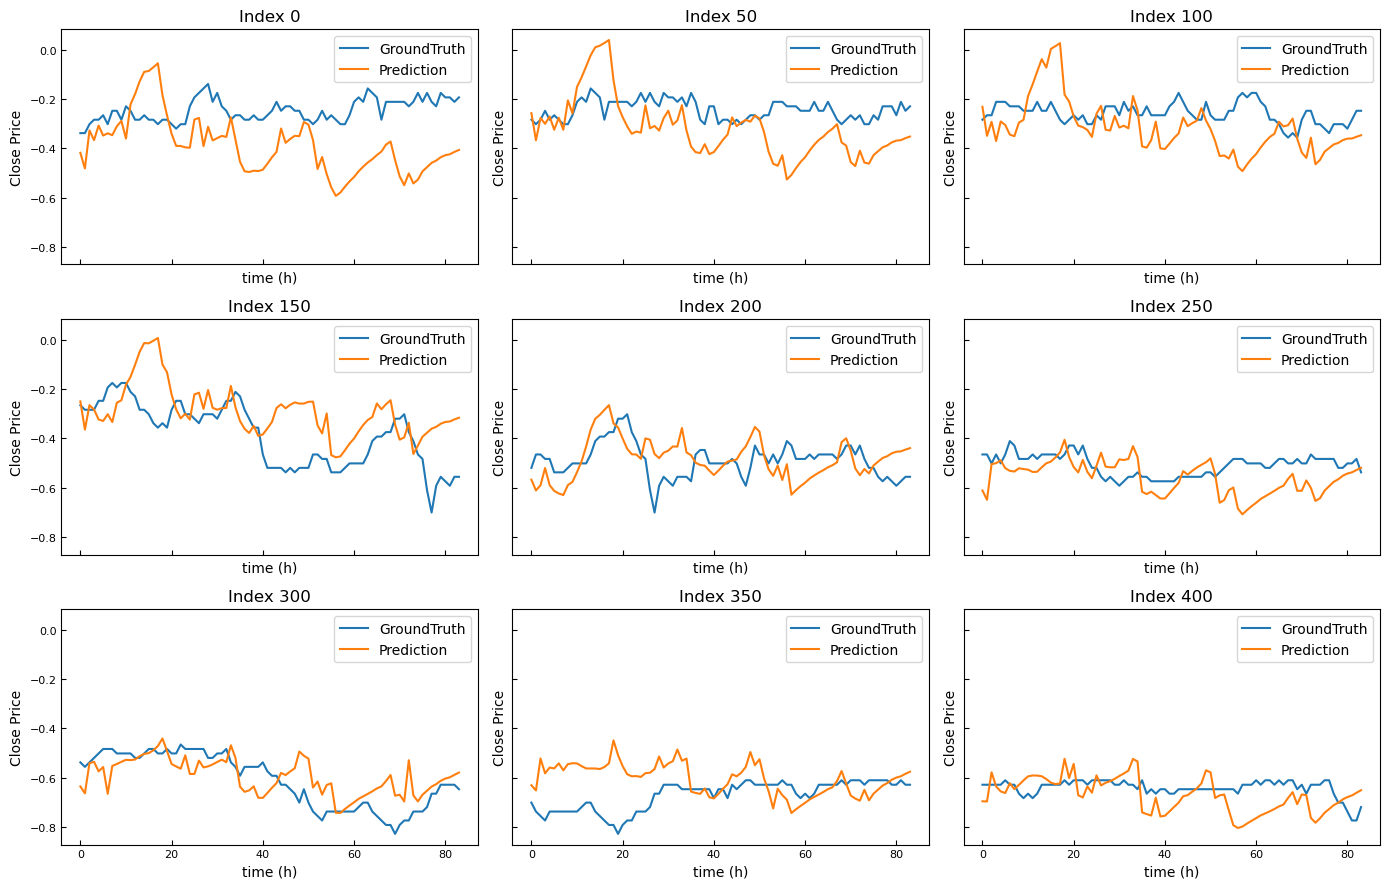

In [ ]:
plot_predictions(trues, preds, start_index=0, step=50, num_plots=9)

In [14]:
import glob
import os
import operator

search_dir = "./informer_checkpoints/"
dirs = os.listdir(search_dir)
dir_list = []
for d in dirs:
    date_change = os.path.getmtime(search_dir + d)
    dir_list.append({'directory_name': d, 'changed_date': date_change})

sorted(dir_list, key=lambda x: x['changed_date'], reverse=True)[0]['directory_name']


'informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0'

In [19]:
import numpy as np
p = np.arange(12)
q = p.reshape(2,2,3)
print('p', p)
print('q ', q)
print(q.shape)

p [ 0  1  2  3  4  5  6  7  8  9 10 11]
q  [[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]
(2, 2, 3)


In [23]:
import csv
import numpy as np
fil_name = 'file'
example = np.zeros((2,3,4))
print('example shape ', example.shape)
example = example.tolist()
with open(fil_name+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(example)

#to read file you saved
with open(fil_name+'.csv', 'r') as f:
  reader = csv.reader(f)
  examples = list(reader)

print(examples)
nwexamples = []
for row in examples:
    nwrow = []
    for r in row:
        nwrow.append(eval(r))
    nwexamples.append(nwrow)
print(nwexamples)
nwa = np.array(nwexamples)
print('newexamples shape ', nwa.shape)

example shape  (2, 3, 4)
[['[0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0]'], ['[0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0]']]
[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]]
newexamples shape  (2, 3, 4)


In [157]:
# import pandas as pd
# data = []
# def get_new_data(time_id,id, x1, x2, x3, y):
#     return {'time_id':time_id,'stock_id':id,'x1':x1,'x2':x2,'x3':x3, 'y': y}

# data.append(get_new_data(1,'a', 'a1x1', 'a1x2', 'a1x3', 'a1y1'))
# data.append(get_new_data(1,'b', 'b1x1', 'b1x2', 'b1x3', 'b1y1'))
# # data.append(get_new_data(1,'c', 'c1x1', 'c1x2', 'c1x3', 'c1y1'))
# data.append(get_new_data(2,'a', 'a2x1', 'a2x2', 'a2x3', 'a2y2'))
# data.append(get_new_data(2,'b', 'b2x1', 'b2x2', 'b2x3', 'b2y2'))
# # data.append(get_new_data(2,'c', 'c2x1', 'c2x2', 'c2x3', 'c2y1'))
# data.append(get_new_data(3,'a', 'a3x1', 'a3x2', 'a3x3', 'a3y3'))
# data.append(get_new_data(3,'b', 'b3x1', 'b3x2', 'b3x3', 'b3y3'))
# # data.append(get_new_data(3,'c', 'c3x1', 'c3x2', 'c3x3', 'c3y1'))


# # data.append(get_new_data(1,'a', 1, 1, 1, 2))
# # data.append(get_new_data(1,'b', 3, 3, 3, 4))
# # data.append(get_new_data(2,'a', 5, 5, 5, 6))
# # data.append(get_new_data(2,'b', 7, 7, 7, 8))
# # data.append(get_new_data(3,'a', 9, 9, 9, 10))
# # data.append(get_new_data(3,'b', 11, 11, 11, 12))

# data_df = pd.DataFrame(data)
# data_df


,time_id,stock_id,x1,x2,x3,y
0,1,a,1,1,1,2
1,1,b,3,3,3,4
2,2,a,5,5,5,6
3,2,b,7,7,7,8
4,3,a,9,9,9,10
5,3,b,11,11,11,12


,time_id,stock_id,y,x1,x2
0,t1,s1,t1s1y,t1s1x1,t1s1x2
1,t1,s2,t1s2y,t1s2x1,t1s2x2
2,t1,s3,t1s3y,t1s3x1,t1s3x2
3,t1,s4,t1s4y,t1s4x1,t1s4x2
4,t2,s1,t2s1y,t2s1x1,t2s1x2
5,t2,s2,t2s2y,t2s2x1,t2s2x2
6,t2,s3,t2s3y,t2s3x1,t2s3x2
7,t2,s4,t2s4y,t2s4x1,t2s4x2
8,t3,s1,t3s1y,t3s1x1,t3s1x2
9,t3,s2,t3s2y,t3s2x1,t3s2x2


,time_id,stock_id,y,1,2
0,1,1,2,3,4
1,1,2,3,4,5
2,1,3,4,5,6
3,1,4,5,6,7
4,2,1,3,4,5
5,2,2,4,5,6
6,2,3,5,6,7
7,2,4,6,7,8
8,3,1,4,5,6
9,3,2,5,6,7


time_ids  ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10']
stock_ids  ['s1', 's2', 's3', 's4']
features  ['y', 'x1', 'x2']
stock_data_np shape  (5, 2, 4, 3)
[[['t1s1y' 't1s1x1' 't1s1x2']
  ['t1s2y' 't1s2x1' 't1s2x2']
  ['t1s3y' 't1s3x1' 't1s3x2']
  ['t1s4y' 't1s4x1' 't1s4x2']]

 [['t2s1y' 't2s1x1' 't2s1x2']
  ['t2s2y' 't2s2x1' 't2s2x2']
  ['t2s3y' 't2s3x1' 't2s3x2']
  ['t2s4y' 't2s4x1' 't2s4x2']]]
time_ids  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
stock_ids  [1, 2, 3, 4]
features  ['y', 1, 2]
stock data num shape  (5, 2, 4, 3)
[[[2 3 4]
  [3 4 5]
  [4 5 6]
  [5 6 7]]

 [[3 4 5]
  [4 5 6]
  [5 6 7]
  [6 7 8]]]


array([[['t1s1y', 't1s1x1', 't1s1x2'],
        ['t1s2y', 't1s2x1', 't1s2x2'],
        ['t1s3y', 't1s3x1', 't1s3x2'],
        ['t1s4y', 't1s4x1', 't1s4x2']],

       [['t2s1y', 't2s1x1', 't2s1x2'],
        ['t2s2y', 't2s2x1', 't2s2x2'],
        ['t2s3y', 't2s3x1', 't2s3x2'],
        ['t2s4y', 't2s4x1', 't2s4x2']]], dtype='<U7')

orig shape  (5, 2, 4, 3)
orig data  [[['t1s1y' 't1s1x1' 't1s1x2']
  ['t1s2y' 't1s2x1' 't1s2x2']
  ['t1s3y' 't1s3x1' 't1s3x2']
  ['t1s4y' 't1s4x1' 't1s4x2']]

 [['t2s1y' 't2s1x1' 't2s1x2']
  ['t2s2y' 't2s2x1' 't2s2x2']
  ['t2s3y' 't2s3x1' 't2s3x2']
  ['t2s4y' 't2s4x1' 't2s4x2']]]
transpose data asu  (5, 4, 2, 3)


array([[['t1s1y', 't1s1x1', 't1s1x2'],
        ['t2s1y', 't2s1x1', 't2s1x2']],

       [['t1s2y', 't1s2x1', 't1s2x2'],
        ['t2s2y', 't2s2x1', 't2s2x2']],

       [['t1s3y', 't1s3x1', 't1s3x2'],
        ['t2s3y', 't2s3x1', 't2s3x2']],

       [['t1s4y', 't1s4x1', 't1s4x2'],
        ['t2s4y', 't2s4x1', 't2s4x2']]], dtype='<U7')

array([['t1s1y', 't1s2y', 't1s3y', 't1s4y'],
       ['t2s1y', 't2s2y', 't2s3y', 't2s4y']], dtype='<U7')

array([[['t1s1x1', 't1s1x2'],
        ['t1s2x1', 't1s2x2'],
        ['t1s3x1', 't1s3x2'],
        ['t1s4x1', 't1s4x2']],

       [['t2s1x1', 't2s1x2'],
        ['t2s2x1', 't2s2x2'],
        ['t2s3x1', 't2s3x2'],
        ['t2s4x1', 't2s4x2']]], dtype='<U7')

In [ ]:


# data.append(get_new_data(1,'a', 'a1x1', 'a1x2', 'a1x3', 'a1y1'))
# data.append(get_new_data(1,'b', 'b1x1', 'b1x2', 'b1x3', 'b1y1'))
# data.append(get_new_data(2,'a', 'a2x1', 'a2x2', 'a2x3', 'a2y2'))
# data.append(get_new_data(2,'b', 'b2x1', 'b2x2', 'b2x3', 'b2y2'))
# data.append(get_new_data(3,'a', 'a3x1', 'a3x2', 'a3x3', 'a3y3'))
# data.append(get_new_data(3,'b', 'b3x1', 'b3x2', 'b3x3', 'b3y3'))

# data_df = pd.DataFrame(data)
# display(data_df)

# sample_3d = create_3d_stock_data(data_df)
# print('sample_3d shape ', sample_3d.shape)

# # single record contains record for one time id
# # first_record = sample_3d[0]
# # print('first_record ', first_record)

# # first_stock_record = first_record[0]
# # print('first_stock_record ', first_stock_record)

# # target_data = first_stock_record[-1]
# # print('target_data ', target_data)

# print('Batch record')
# # batch record, suppose 2 time id
# batch_record = sample_3d[0:2]
# print('batch_record ', batch_record)

# features = batch_record[:,:,0:-1]
# print('\nfeatures ', features)
# targets = batch_record[:,:,-1]
# print('\ntargets ', targets)

# stock(num_stock), time_id(window_len), features (num_features)
# inputs: [batch - splits the time_id, num_stock, window_len, num_features]

In [ ]:
# all_all_data = []
# batch_size = 2
# row_start = 0
# num_of_iterations = len(sample_3d) / batch_size
# for i in range(num_of_iterations)
# batch_record = sample_3d[0:2]

stocks data shape  (5, 2, 4, 3)
row_data shape  (2, 4, 3)
row_data [[[2 3 4]
  [3 4 5]
  [4 5 6]
  [5 6 7]]

 [[3 4 5]
  [4 5 6]
  [5 6 7]
  [6 7 8]]]
features  [[3 4]
 [4 5]
 [5 6]
 [6 7]]
targets  [2 3 4 5]
stocks data shape  (5, 2, 4, 3)
row_data shape  (2, 4, 3)
row_data [[[ 4  5  6]
  [ 5  6  7]
  [ 6  7  8]
  [ 7  8  9]]

 [[ 5  6  7]
  [ 6  7  8]
  [ 7  8  9]
  [ 8  9 10]]]
features  [[5 6]
 [6 7]
 [7 8]
 [8 9]]
targets  [4 5 6 7]
stocks data shape  (5, 2, 4, 3)
row_data shape  (2, 4, 3)
row_data [[[ 6  7  8]
  [ 7  8  9]
  [ 8  9 10]
  [ 9 10 11]]

 [[ 7  8  9]
  [ 8  9 10]
  [ 9 10 11]
  [10 11 12]]]
features  [[ 7  8]
 [ 8  9]
 [ 9 10]
 [10 11]]
targets  [6 7 8 9]
stocks data shape  (5, 2, 4, 3)
row_data shape  (2, 4, 3)
row_data [[[ 8  9 10]
  [ 9 10 11]
  [10 11 12]
  [11 12 13]]

 [[ 9 10 11]
  [10 11 12]
  [11 12 13]
  [12 13 14]]]
features  [[ 9 10]
 [10 11]
 [11 12]
 [12 13]]
targets  [ 8  9 10 11]
stocks data shape  (5, 2, 4, 3)
row_data shape  (2, 4, 3)
row_data [[[10

all_stock_df  (3830, 10)
all_stock_df  (7660, 10)


,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,time_id,stock_id
0,303.000854,303.259064,302.947845,303.304626,23636,22523,24426,27111,5,0
1,200.002258,200.081116,199.973907,200.108109,29993,14229,19089,18979,11,0
2,187.850311,187.986603,187.813354,188.023834,18073,24635,21531,14035,16,0
3,119.813408,119.916534,119.790642,119.929535,13735,14496,8254,15747,31,0
4,175.895645,175.965515,175.862076,175.984711,21089,15572,15460,8286,62,0
...,...,...,...,...,...,...,...,...,...,...
7655,306.944916,307.128357,306.896698,307.164642,23250,18401,20104,29174,32751,1
7656,497.494507,497.954102,497.415863,498.016022,63667,91691,42370,82785,32753,1
7657,313.132782,313.335693,313.088776,313.376862,38901,22370,44453,27803,32758,1
7658,435.233521,435.416931,435.151245,435.517181,55774,65126,50106,57416,32763,1


,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


,stock_id,time_id,target
0,0,5,0.004136
3830,1,5,0.006340
1,0,11,0.001445
3831,1,11,0.002099
2,0,16,0.002168
...,...,...,...
3827,0,32758,0.004264
7658,1,32763,0.004902
3828,0,32763,0.004352
3829,0,32767,0.001084


,time_id,stock_0,stock_1
0,5,0.004136,0.006340
1,11,0.001445,0.002099
2,16,0.002168,0.002456
3,31,0.002195,0.002807
4,62,0.001747,0.004312
...,...,...,...
3825,32751,0.002611,0.003741
3826,32753,0.001190,0.012414
3827,32758,0.004264,0.002868
3828,32763,0.004352,0.004902


,time_id,stock_0,stock_1
0,5,0.004136,0.006340
1,11,0.001445,0.002099
2,16,0.002168,0.002456
3,31,0.002195,0.002807
4,62,0.001747,0.004312
...,...,...,...
3825,32751,0.002611,0.003741
3826,32753,0.001190,0.012414
3827,32758,0.004264,0.002868
3828,32763,0.004352,0.004902


array([0.00413577])

In [1]:
all_stock_df

NameError: name 'all_stock_df' is not defined

time_ids  [5, 11, 16, 31, 62, 72, 97, 103, 109, 123, 128, 146, 147, 152, 157, 159, 169, 207, 211, 213, 218, 227, 229, 232, 250, 254, 256, 266, 273, 289, 297, 303, 309, 310, 317, 319, 325, 326, 335, 337, 358, 371, 373, 380, 381, 411, 420, 424, 427, 436, 438, 454, 465, 468, 487, 493, 506, 535, 536, 539, 545, 554, 568, 579, 589, 591, 595, 611, 618, 627, 633, 640, 646, 650, 652, 659, 675, 697, 709, 725, 728, 735, 745, 746, 748, 753, 785, 817, 840, 841, 852, 854, 868, 886, 895, 904, 908, 947, 951, 957, 969, 985, 991, 1000, 1011, 1016, 1020, 1022, 1028, 1037, 1040, 1057, 1063, 1070, 1075, 1100, 1107, 1119, 1125, 1128, 1135, 1142, 1149, 1158, 1161, 1173, 1176, 1178, 1191, 1198, 1205, 1209, 1213, 1215, 1219, 1227, 1235, 1239, 1242, 1247, 1249, 1255, 1264, 1269, 1273, 1274, 1280, 1289, 1291, 1292, 1302, 1310, 1321, 1322, 1326, 1348, 1350, 1359, 1363, 1365, 1377, 1380, 1392, 1404, 1408, 1416, 1417, 1427, 1430, 1433, 1459, 1462, 1463, 1464, 1468, 1471, 1477, 1481, 1501, 1513, 1521, 1524, 1529, 15

In [68]:
type(stock_4d)

numpy.ndarray

p  (957, 4, 2, 9)


In [71]:
stock_4d[0]

array([[[3.03000854e+02, 3.03259064e+02, 3.02947845e+02, 3.03304626e+02,
         2.36360000e+04, 2.25230000e+04, 2.44260000e+04, 2.71110000e+04,
         4.13576700e-03],
        [5.76905212e+02, 5.77288269e+02, 5.76840393e+02, 5.77351440e+02,
         3.57500000e+04, 6.37770000e+04, 3.11720000e+04, 3.47220000e+04,
         6.34014400e-03]],

       [[2.00002258e+02, 2.00081116e+02, 1.99973907e+02, 2.00108109e+02,
         2.99930000e+04, 1.42290000e+04, 1.90890000e+04, 1.89790000e+04,
         1.44458700e-03],
        [3.70567993e+02, 3.70747314e+02, 3.70524841e+02, 3.70785828e+02,
         2.78880000e+04, 3.20410000e+04, 2.97650000e+04, 3.07610000e+04,
         2.09906800e-03]],

       [[1.87850311e+02, 1.87986603e+02, 1.87813354e+02, 1.88023834e+02,
         1.80730000e+04, 2.46350000e+04, 2.15310000e+04, 1.40350000e+04,
         2.16818900e-03],
        [3.53292084e+02, 3.53392578e+02, 3.53250214e+02, 3.53433380e+02,
         5.74090000e+04, 5.34190000e+04, 5.10600000e+04, 5.9125

In [52]:
import os
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

from torch.utils.data import DataLoader
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import json
import time
import shutil

def remove_directory(dir_path):
    if os.path.exists(dir_path):
        print('removing directory ', dir_path)
        shutil.rmtree(dir_path)

def run_volatility(data_path, target_column, target_config_list_m, forecasting_task, target_config_list_ms):
    
    remove_directory('./informer_checkpoints/')
    remove_directory('./results/')
    args = dotdict()

    ROOT_DIR = './dataset/'
    args.is_time_id = True
    data_path = data_path
    # if args.is_time_id:
    #     data_path = file_name
    #     # data_path = 'AAPL_reduced_time_id.csv'
    #     # data_path = 'stock_data_targets.csv'
    #     data_path = 'stock_data_tcn_targets.csv'
    # else:
    #     data_path = 'AAPL_reduced.csv'
    # target_column = 'close'
    # target_column = 'stock_0_y'

    target_column = target_column

    args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

    args.data = 'custom' # data
    args.root_path =  ROOT_DIR#'/content/' # root path of data file
    args.data_path = data_path#'output.csv' # data file
    args.features = forecasting_task # forecasting task, options:[M, S, MS];
                        #M:multivariate predict multivariate, S:univariate predict univariate,
                        #MS:multivariate predict univariate
    args.target = target_column # target feature in S or MS task
    args.freq = '1m' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
    args.checkpoints = './informer_checkpoints' # location of model checkpoints

    args.seq_len = 96 # input sequence length of Informer encoder
    args.label_len = 48 # start token length of Informer decoder
    args.pred_len = 84 # prediction sequence length
    # Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

    args.enc_in = 8 # encoder input size
    args.dec_in = 8 # decoder input size
    args.c_out = 8 # output size
    args.factor = 5 # probsparse attn factor
    args.d_model = 512 # dimension of model
    args.n_heads = 8 # num of heads
    args.e_layers = 2 # num of encoder layers
    args.d_layers = 1 # num of decoder layers
    args.d_ff = 2048 # dimension of fcn in model
    args.dropout = 0.05 # dropout
    args.attn = 'prob' # attention used in encoder, options:[prob, full]
    args.embed = 'fixed' # time features encoding, options:[timeF, fixed, learned]
    args.activation = 'gelu' # activation
    args.distil = True # whether to use distilling in encoder
    args.output_attention = False # whether to output attention in ecoder
    args.mix = True
    args.padding = 0
    args.freq = 'h'

    args.batch_size = 32
    args.learning_rate = 0.0001
    args.loss = 'mse'
    args.lradj = 'type1'
    args.use_amp = False # whether to use automatic mixed precision training

    args.num_workers = 0
    args.itr = 1
    args.train_epochs = 2
    args.patience = 3
    args.des = 'exp'

    args.use_gpu = True if torch.cuda.is_available() else False
    args.gpu = 0

    args.use_multi_gpu = False
    args.devices = '0,1,2,3'

    args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

    if args.use_gpu and args.use_multi_gpu:
        args.devices = args.devices.replace(' ','')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]

    # Set augments by using data name
    data_parser = {
        'custom':{'data':data_path,
                'T':target_column,
                #   'M':[2,2,2],
                # 'M':[4,4,4],
                'M': target_config_list_m,
                #   'M':[5,5,5],
                'S':[1,1,1],
                'MS':target_config_list_ms}, #Change the array here based on the number of features
    }
    if args.data in data_parser.keys():
        data_info = data_parser[args.data]
        args.data_path = data_info['data']
        args.target = data_info['T']
        args.enc_in, args.dec_in, args.c_out = data_info[args.features]

    args.detail_freq = args.freq
    args.freq = args.freq[-1:]

    Exp = Exp_Informer
    print('Args in experiment:')
    print(args)

    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                    args.seq_len, args.label_len, args.pred_len,
                    args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

        # set experiments
        exp = Exp(args)

        # train
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)

        # test
        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

        print('Finished training')
        # torch.cuda.empty_cache()

    search_dir = "./informer_checkpoints/"
    dirs = os.listdir(search_dir)
    dir_list = []
    for d in dirs:
        if d.lower() == '.ds_store':
            continue
        date_change = os.path.getmtime(search_dir + d)
        dir_list.append({'directory_name': d, 'changed_date': date_change})

    # sorted(dir_list, key=lambda x: x['changed_date'], reverse=True)[0]['directory_name']

    # set saved model path
    # setting = 'informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
    setting = sorted(dir_list, key=lambda x: x['changed_date'], reverse=True)[0]['directory_name']
    print('setting folder ', setting)
    # path = os.path.join(args.checkpoints,setting,'checkpoint.pth')


    # If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
    # Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
    # If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

    exp = Exp(args)

    exp.predict(setting, True)

    prediction = np.load('./results/'+setting+'/real_prediction.npy')

    prediction.shape

    Data = Dataset_Pred
    timeenc = 0 if args.embed!='timeF' else 1
    flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

    freq = args.detail_freq

    data_set = Data(
        root_path=args.root_path,
        is_time_id=args.is_time_id,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq
    )
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)

    len(data_set), len(data_loader)

    # When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
    # The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

    preds = np.load('./results/'+setting+'/pred.npy')
    trues = np.load('./results/'+setting+'/true.npy')

    # [samples, pred_len, dimensions]
    preds.shape, trues.shape

    import matplotlib.pyplot as plt

    def plot_predictions(trues, preds, start_index, step, num_plots):
        num_rows = num_plots // 3
        num_cols = 3

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 3 * num_rows), sharex=True, sharey=True)

        for i, ax in enumerate(axes.flatten()):
            if i < num_plots:
                index = start_index + i * step

                ax.plot(trues[index, :, -1], label='GroundTruth')
                ax.plot(preds[index, :, -1], label='Prediction')

                ax.set_title(f'Index {index}')
                ax.legend()
                ax.set_xlabel('time (h)')
                ax.set_ylabel('Close Price')
                ax.tick_params(axis='both', which='both', labelsize=8, direction='in')

            else:
                ax.axis('off')


        plt.tight_layout()
        plt.show()

    plot_predictions(trues, preds, start_index=0, step=50, num_plots=6)


Args in experiment:
{'is_time_id': True, 'model': 'informer', 'data': 'custom', 'root_path': './dataset/', 'data_path': 'stock_data_targets.csv', 'features': 'M', 'target': 'stock_0', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 84, 'enc_in': 2, 'dec_in': 2, 'c_out': 2, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 2, 'patience': 3, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}
using mps device
>>>>>>>start training : informer_custom_ftM_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
custom data set


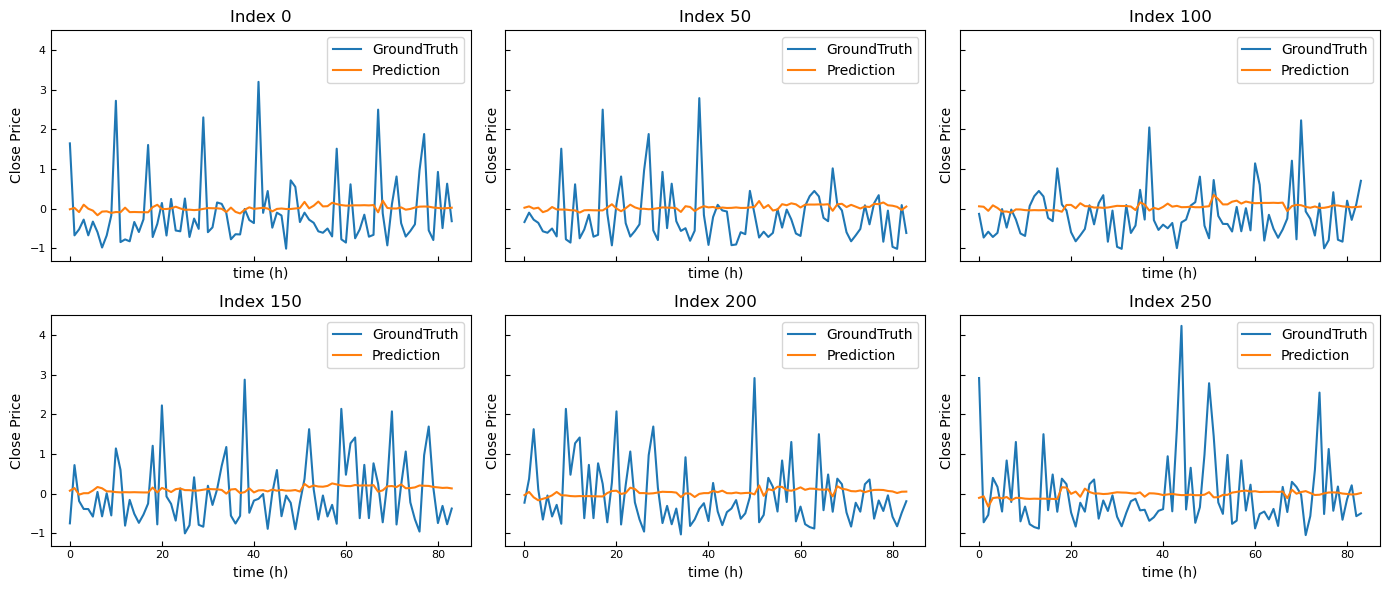

In [53]:
run_volatility('stock_data_targets.csv', 'stock_0', [2,2,2], 'M', [])

Args in experiment:
{'is_time_id': True, 'model': 'informer', 'data': 'custom', 'root_path': './dataset/', 'data_path': 'stock_data_tcn_targets.csv', 'features': 'M', 'target': 'stock_0_y', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 84, 'enc_in': 4, 'dec_in': 4, 'c_out': 4, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 2, 'patience': 3, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}
using mps device
>>>>>>>start training : informer_custom_ftM_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
custom dat

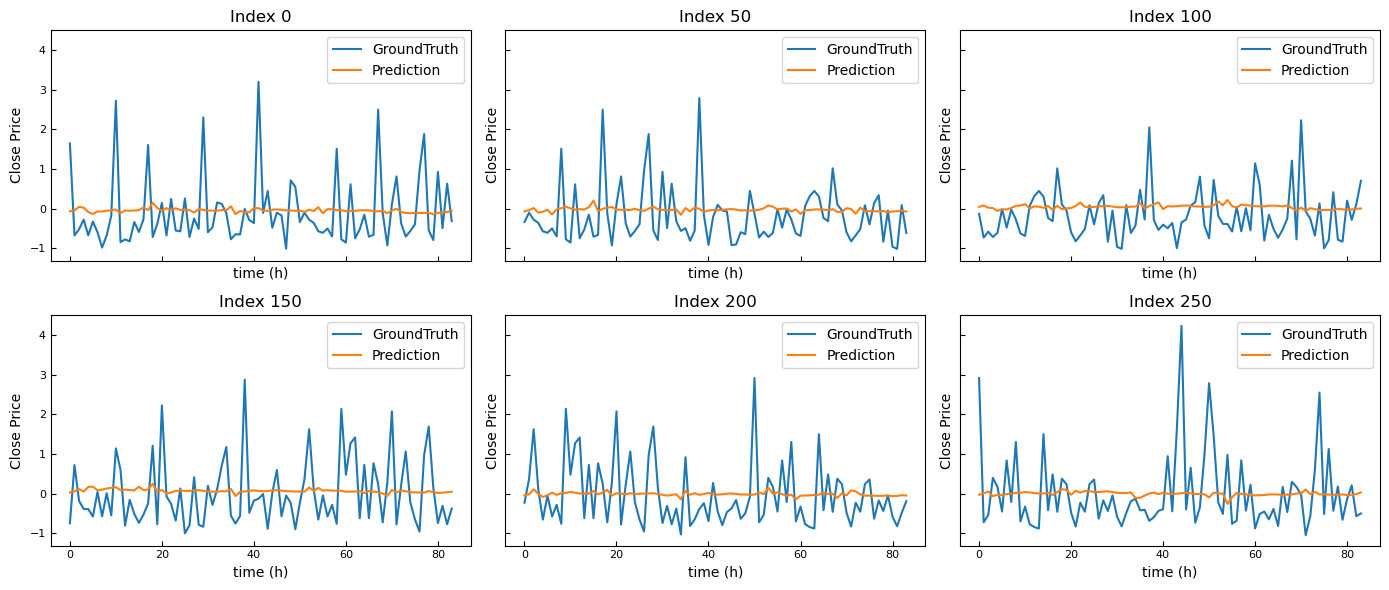

In [43]:
run_volatility('stock_data_tcn_targets.csv', 'stock_0_y', [4,4,4], 'M', [])

Args in experiment:
{'is_time_id': True, 'model': 'informer', 'data': 'custom', 'root_path': './dataset/', 'data_path': 'stock_0_features.csv', 'features': 'MS', 'target': 'target', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 84, 'enc_in': 9, 'dec_in': 9, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 2, 'patience': 3, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}
using mps device
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
custom data set
d

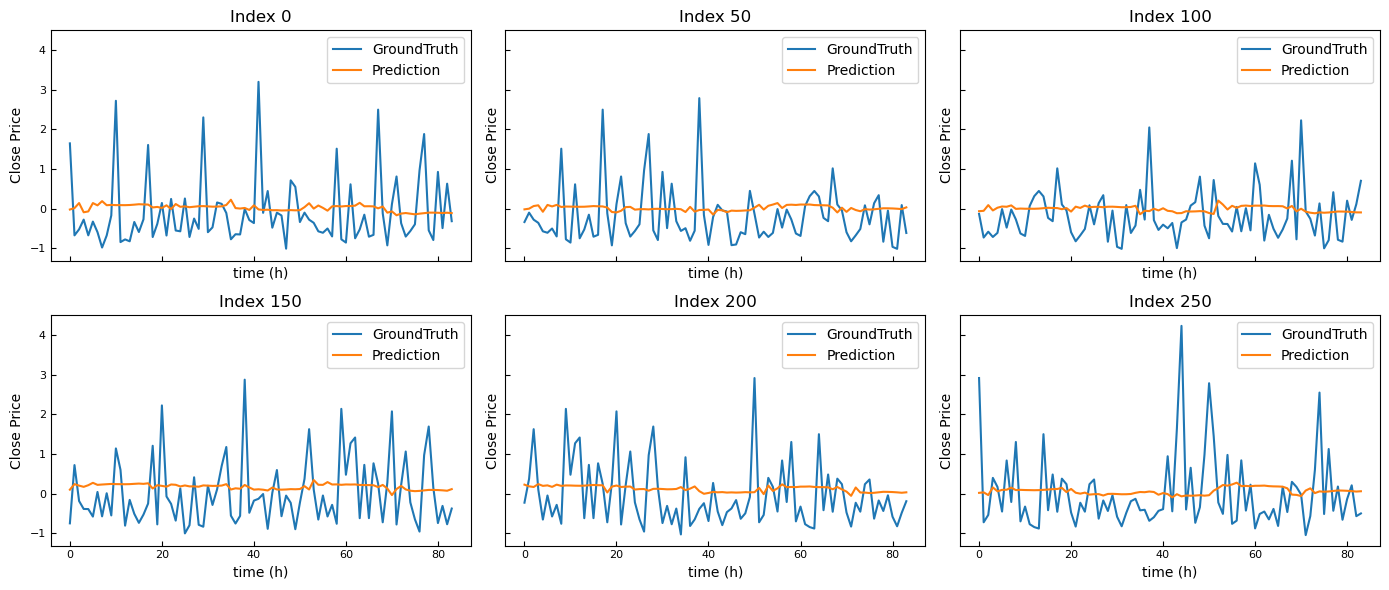

In [42]:
run_volatility('stock_0_features.csv', 'target', [4,4,4], 'MS', [9,9,1])